# Оптимизация потребления электроэнергии на этапе обработки стали
Цель:
Построение модели, предсказывающей температуру стали, чтобы оптимизировать производственные расходы металлургического комбината **ООО «Так закаляем сталь»**.

# Этапы обработки стали:
### Подготовка ковша:

- Обработка в металлическом ковше вместимостью ~100 тонн.
- Внутренняя облицовка ковша огнеупорным кирпичом для выдерживания высоких температур.

### Обработка стали:

- Заливка расплавленной стали в ковш.
- Подогрев с использованием графитовых электродов.
- Десульфурация сплава и коррекция химического состава.
- Отбор проб для анализа.
- Легирование стали с использованием сыпучих материалов или проволоки.

### Измерение и анализ:

- Измерение температуры и химический анализ перед добавлением легирующих добавок.
- Повышение температуры и добавление легирующих материалов.
- Продувка инертным газом, перемешивание и повторное измерение.

### Завершающие этапы:

- Отправка стали на доводку металла или в машину непрерывной разливки.
- Получение готового продукта в виде заготовок-слябов.

### Описание данных:
- `data_arc_new.csv`:  Данные о электродах.
- `data_bulk_new.csv`:  Объемные данные о подаче сыпучих материалов.
- `data_bulk_time_new.csv`:  Временные данные о подаче сыпучих материалов.
- `data_gas_new.csv`:  Данные о продувке сплава газом.
- `data_temp_new.csv`:  Результаты измерения температуры.
- `data_wire_new.csv`:  Объемные данные о проволочных материалах.
- `data_wire_time_new.csv`:  Временные данные о проволочных материалах.

### Примечание:
Во всех файлах столбец key содержит номер партии. Несколько строк с одинаковым значением key соответствуют разным итерациям обработки.
Данные также находятся в тренажёре, в папке /datasets/.



<font color='blue'><b>Комментарий тимлида</b></font><br>
<br><font color='green'> ✔️ Название и описание на месте.</font>

# План работы:
**1. Импортирование данных**

 - Загрузим данные из источника.
 - Ознакомимся с первичной структурой и форматом данных.
 
**2. Исследовательский анализ данных (EDA)**

 - Посмотрим на статистические показатели (среднее, медиана, стандартное отклонение и т.д.).
 - Визуализируем распределения ключевых признаков.
 - Изучим корреляцию между признаками.
 - Определим наличие выбросов и пропущенных значений.
 
**3. Предобработка данных**

 - Обработаем пропущенные значения (если они есть).
 - Произведем кодирование категориальных признаков.
 - Масштабируем признаки, если это необходимо.
 
**4. Подготовка данных к моделированию**

 - Определим целевой признак и основные признаки.
 - Удалим лишние колонки или неинформативные признаки.
 - Если необходимо, объединим разные источники данных в одну таблицу по ключевым признакам.

**5. Разработка моделей машинного обучения**

- Разделение данных на обучающую, валидационную и тестовую выборки.
- Применим следующие алгоритмы:
- `XGBoost`: Подберем оптимальные параметры с помощью кросс-валидации.
- `CatBoost`: Произведем настройку и подбор параметров.
- `LightGBM`: Аналогично проведем настройку.
- `LinearRegression`: Обучим модель, проверим предпосылки линейной регрессии (если необходимо).

**6. Оценка и сравнение моделей**

- Оценим качество каждой модели на валидационной выборке.
- Сравним показатели качества и выберем наилучшую модель.

**7. Тестирование**

- Протестируем выбранную модель на отдельной тестовой выборке.
- Оценим ее общую производительность.

**8. Отчет**

- Подведем итоги работы.
- Проанализируем ключевые трудности и проблемы, с которыми столкнулись.
- Дадим рекомендации по дальнейшему использованию или улучшению модели.

**9. Примечания**

 - random_state = 140823
 - Задача регрессии, не временного ряда
 - Объединение таблиц по ключам, которые есть во всех таблицах
 - Выводы по каждому этапу
 - Анализ данных после объединения
 - Train:test – 3:1
 - Выбросы удалить только из обучающей выборки


<font color='blue'><b>Комментарий тимлида</b></font><br>
<br><font color='green'> ✔️ Очень подробный план</font>

In [53]:
# Импорт стандартных библиотек
import os
import math
import time
import itertools 
import urllib.request
import warnings
from pathlib import Path
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor


# Импорт библиотек для работы с данными
import numpy as np
import pandas as pd

# Импорт библиотек визуализации
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Импорт библиотек машинного обучения
import xgboost
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score


# Установка конфигураций и настроек
warnings.filterwarnings('ignore')
random_state = 140823
sns.set_style("whitegrid")
sns.set_context("talk")
from tqdm.notebook import tqdm

## Импортирование данных

In [54]:
# Список файлов для загрузки
files = [
    "data_arc_new.csv",
    "data_bulk_new.csv",
    "data_bulk_time_new.csv",
    "data_gas_new.csv",
    "data_temp_new.csv",
    "data_wire_new.csv",
    "data_wire_time_new.csv"
]

# Базовый путь до файлов
base_path = "/datasets/"

# Словарь, содержащий загруженные данные
datasets = {}

# Загрузка данных в словарь
for file in files:
    # Используем os.path.join для соединения базового пути и имени файла
    file_path = os.path.join(base_path, file)
    # Извлекаем имя файла без расширения для использования в качестве ключа словаря
    key_name = file.split("_new.csv")[0]
    datasets[key_name] = pd.read_csv(file_path)


**2. Исследовательский анализ данных (EDA)**

In [55]:
def analyze_data(data):
    """
    Анализирует и выводит основную информацию о переданном наборе данных.
    
    Параметры:
        data (DataFrame): DataFrame для анализа.
    """
    
    # Основная информация о DataFrame
    print("Базовая информация о данных:")
    data.info()
    
    # Вывод первых 10 строк
    print("\nПервые 10 строк:")
    display(data.head(10))
    
    # Статистическая информация
    print("\nОсновные статистические показатели:")
    display(data.describe())
    
    # Количество дубликатов
    print(f"\nКол-во дубликатов: {data.duplicated().sum()}")

    
def graph(data, parametr, bins=30):
    fig = plt.figure(figsize=(15, 6), dpi=80)
    grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.2)
    ax_main = fig.add_subplot(grid[:-1, :-1])
    ax_right = fig.add_subplot(grid[:-1, -1], yticklabels=[])  # уберем метки по y, чтобы избежать дублирования
    
    # График плотности
    sns.kdeplot(data[parametr], ax=ax_main, fill=True, alpha=0.6, linewidth=1.5)
    sns.histplot(data[parametr], ax=ax_main, color='lightgray', bins=bins, kde=False, stat="density")
    
    # Boxplot
    sns.boxplot(data[parametr], ax=ax_right, orient='v')
    
    # Подписи графиков
    ax_main.set(title='График распределения ' + parametr, xlabel='', ylabel='Плотность')
    ax_right.set(title='Boxplot ' + parametr, xlabel='', ylabel='')
    
    # Выделение среднего и медианы
    mean_val = np.mean(data[parametr])
    median_val = np.median(data[parametr])
    
    ax_main.axvline(mean_val, color='red', linestyle='--', label=f'Среднее: {mean_val:.2f}')
    ax_main.axvline(median_val, color='blue', linestyle='-', label=f'Медиана: {median_val:.2f}')
    ax_main.legend()
    
    plt.tight_layout()
    plt.show()


<font color='blue'><b>Комментарий тимлида</b></font><br>
<br><font color='green'> ✔️ Хорошее решение по функциям</font>

`Data_arc Dataset` : Данные об электродах

In [56]:
analyze_data(datasets['data_arc'])

Базовая информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB

Первые 10 строк:


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856



Основные статистические показатели:


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284



Кол-во дубликатов: 0


1. Выводы по набору данных data_arc:

Размер набора данных: 14,876 записей и 5 столбцов.
Отсутствие пропущенных значений: Все столбцы содержат 14,876 непропущенных значений.
2. Типы данных:

Целые числа: key
Объекты/Строки: Начало нагрева дугой и Конец нагрева дугой (вероятно, это даты и время в формате строки)
Десятичные числа: Активная мощность и Реактивная мощность
3. Неправильные значения:

Столбец Реактивная мощность содержит отрицательное минимальное значение (-715.479924), что, возможно, является ошибкой или аномалией, которую следует дополнительно исследовать.
4. Дубликаты:

В данных нет дубликатов.
5. Статистическая информация:

Среднее значение активной мощности: 0.662752
Стандартное отклонение активной мощности: 0.258885
Данные по активной мощности распределены от 0.223120 до 1.463773

In [57]:
# Изменим типы данных:
datasets['data_arc']['Начало нагрева дугой'] = pd.to_datetime(datasets['data_arc']['Начало нагрева дугой'])
datasets['data_arc']['Конец нагрева дугой'] = pd.to_datetime(datasets['data_arc']['Конец нагрева дугой'])

datasets['data_arc'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


In [58]:
#Количество партий/ковшей:
len(datasets['data_arc']['key'].unique())

3214

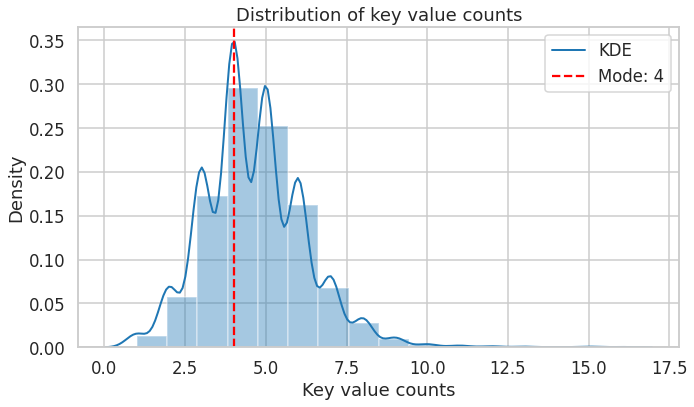

In [59]:
# Установка размера графика
plt.figure(figsize=(10, 6))

# Построение графика плотности распределения
sns.distplot(datasets['data_arc']['key'].value_counts(), bins=16, kde_kws={"lw": 2, "label": "KDE"})

# Вычисление моды
mode = stats.mode(datasets['data_arc']['key'].value_counts())[0][0]
plt.axvline(x=mode, color='red', linestyle='--', label=f'Mode: {mode}')
plt.legend()

# Добавление названия графика и подписей к осям
plt.title('Distribution of key value counts')
plt.xlabel('Key value counts')
plt.ylabel('Density')

# Отображение графика
plt.tight_layout()
plt.show()

- Key (ключ) - это номер партии
- Количество итераций отличается для каждой партии от 1 до 16. Мода (значение в наборе данных, которое встречается наиболее часто) равняется 4.

# Краткое описание электрических мощностей:

- **Активная мощность (Real Power, P)**
  
  - **Единица измерения**: Ватт (W, kW)
  - **Определение**: Среднее значение мгновенной мощности за период \(T\).
  - **Формула**: 
    $$
    P =  {1 \over T} \int\limits_{0}^{T} p(t) dt
    $$

- **Реактивная мощность (Reactive Power, Q)**

  - **Единица измерения**: Вольт-ампер реактивный (var, kvar)
  - **Определение**: Отражает колебания энергии электромагнитного поля из-за фазового сдвига между напряжением и током.
  - **Основная формула**: 
    $$
    Q = U \times I \times Sin(\varphi)
    $$
  - **Связь с активной и полной мощностью**: 
    $$
    | Q | = {\sqrt{S^2 - P^2}}
    $$

- **Полная мощность (Apparent Power, S)**

  - **Единица измерения**: Вольт-ампер (VA, kVA)
  - **Определение**: Мгновенное произведение напряжения и тока.
  - **Основная формула**: 
    $$
    S = U \times I 
    $$ 
  - **Связь с активной и реактивной мощностью**: 
    $$
    S  = {\sqrt{P^2 + Q^2}}
    $$


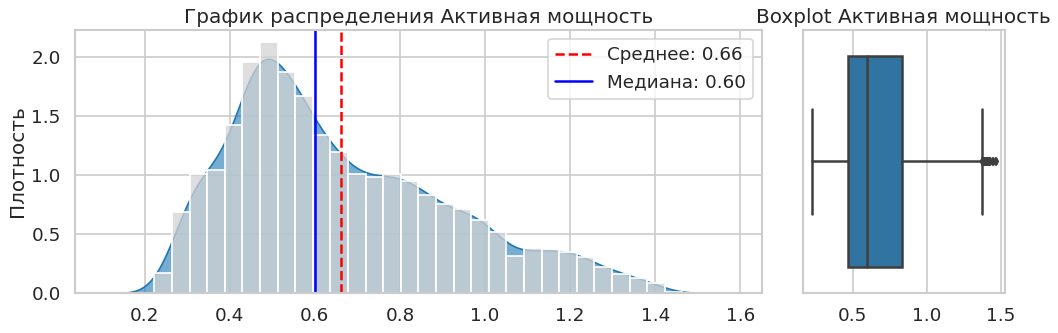

In [60]:
# Распределение активной мощности
graph(datasets['data_arc'], 'Активная мощность')

- распределение похоже на нормальное с левым сдвигом

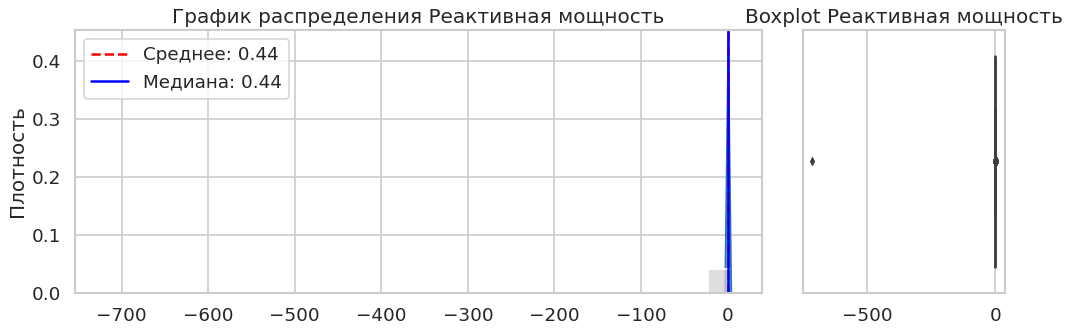

In [61]:
#Распределение реактивной мощности - видно выброс реактивной мощности, от которого стоит избавиться
graph(datasets['data_arc'], 'Реактивная мощность')

In [62]:
#Удалим выброс меньше нуля - такой всего один выброс
datasets['data_arc'] = datasets['data_arc'][datasets['data_arc']['Реактивная мощность'] >= 0]

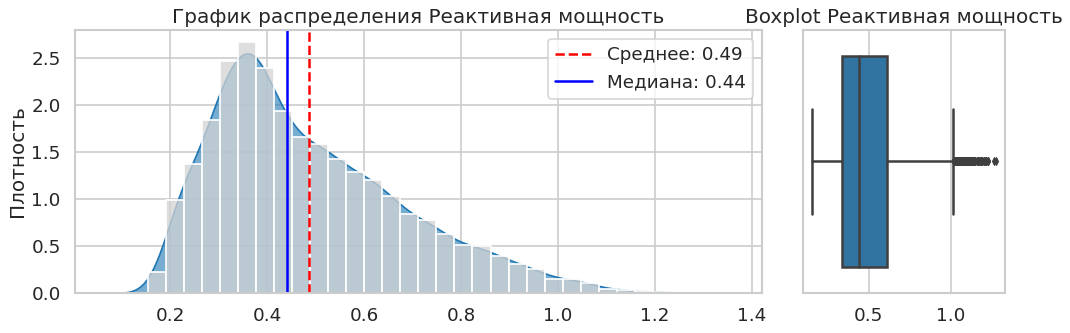

In [63]:
graph(datasets['data_arc'], 'Реактивная мощность')

In [64]:
# данных уменьшилось на одну запись
datasets['data_arc'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14875 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14875 non-null  int64         
 1   Начало нагрева дугой  14875 non-null  datetime64[ns]
 2   Конец нагрева дугой   14875 non-null  datetime64[ns]
 3   Активная мощность     14875 non-null  float64       
 4   Реактивная мощность   14875 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 697.3 KB


Корреляция активной и реактивной мощности: 0.97


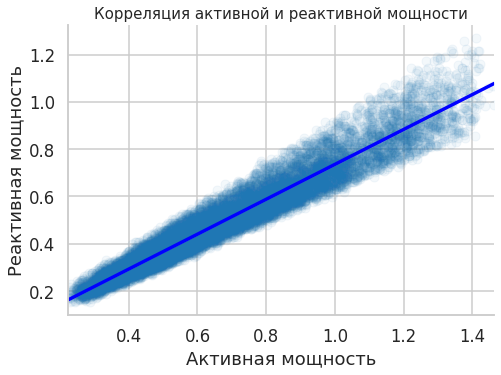

In [65]:
# Вычисляем и печатаем корреляцию между активной и реактивной мощностью
correlation_value = datasets['data_arc']['Активная мощность'].corr(datasets['data_arc']['Реактивная мощность'])
print(f'Корреляция активной и реактивной мощности: {correlation_value:.2f}')

# Создаем точечную диаграмму с линией регрессии между активной и реактивной мощностью
sns.lmplot(x='Активная мощность', y='Реактивная мощность', data=datasets['data_arc'], 
           scatter_kws={'alpha':0.05},  line_kws={'color': 'blue'}, aspect=14/10)

# Устанавливаем заголовок для графика
plt.title('Корреляция активной и реактивной мощности', fontsize=15)

# Отображаем график
plt.show()


Реактивная и активная мощности демонстрируют сильную корреляцию между собой, что может указывать на возможное наличие мультиколлинеарности. Это явление может привести к переобучению модели, поскольку модель может стать чрезмерно чувствительной к малейшим изменениям в данных. Чтобы справиться с этой проблемой, вместо использования обоих признаков напрямую можно рассмотреть создание нового признака, который объединяет информацию из обоих исходных признаков.

"Полная мощность" — это показатель, который объединяет активную и реактивную мощности в одну величину. Она может быть вычислена с использованием формулы для нахождения гипотенузы в прямоугольном треугольнике:

$$ S=\sqrt{P^2+Q^2} $$
 

где:

- S — полная мощность
- P — активная мощность
- Q — реактивная мощность

Используя этот новый признак, мы можем уменьшить потенциальное воздействие мультиколлинеарности на модель и, возможно, улучшить её обобщающую способность.

In [66]:
# Добавим новый признак Полная мощность
datasets['data_arc']['Полная мощность'] = np.sqrt(datasets['data_arc']['Активная мощность']**2 + datasets['data_arc']['Реактивная мощность']**2)


In [67]:
# Добавим новый признак Полная мощность
datasets['data_arc']['Полная мощность'] = np.sqrt(datasets['data_arc']['Активная мощность']**2 + datasets['data_arc']['Реактивная мощность']**2)


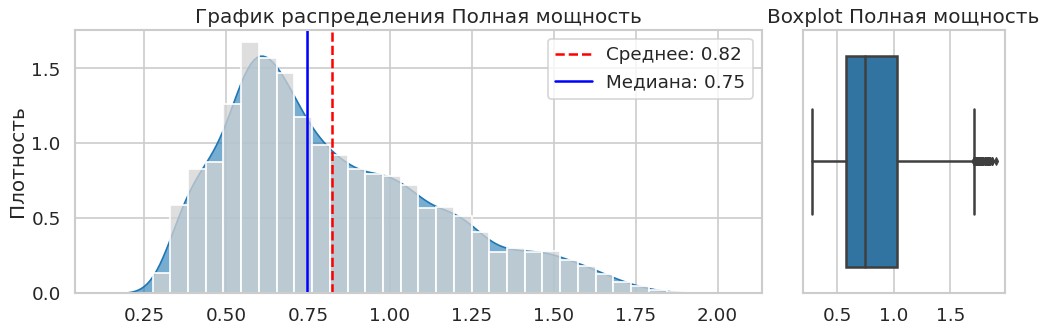

In [68]:
graph(datasets['data_arc'], 'Полная мощность')

Выводы:

1. **Анализ датасета `data_arc`:**
    - Провели первичное изучение датасета.
    - Дубликаты и пропущенные значения отсутствуют.

2. **Предобработка данных:**
    - Преобразовали столбцы 'начало нагрева дугой' и 'конец нагрева дугой' к формату `datetime`.
    - Обнаружили и удалили аномальные значения `-715` в столбце 'Реактивная мощность'.

3. **Исследование активной и реактивной мощности:**
    - Разобрались в сущности активной и реактивной мощности.
    - Из-за высокой корреляции между активной и реактивной мощностями, добавили новый признак 'полная мощность'.


`data_bulk_new` : Объемные данные о подаче сыпучих материалов;

In [69]:
analyze_data(datasets['data_bulk'])

Базовая информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB

Первые 10 строк:


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0



Основные статистические показатели:


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000



Кол-во дубликатов: 0


Выводы:

- **Качество данных**:

 - **Типы данных**: 
    - Все типы данных в датасете указаны корректно.

 - **Дубликаты**: 
    - Дублированные записи в датасете отсутствуют.

- **Пропущенные значения**:

 - Наблюдается значительное количество пропущенных данных. 
 - Причина: для каждой партии используется определённое сочетание сыпучих материалов, что ведёт к отсутствию данных по некоторым из них в различных строках.


`data_gas_new` : Данные о продувке сплава газом;

In [70]:
analyze_data(datasets['data_gas'])

Базовая информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB

Первые 10 строк:


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891



Основные статистические показатели:


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040



Кол-во дубликатов: 0


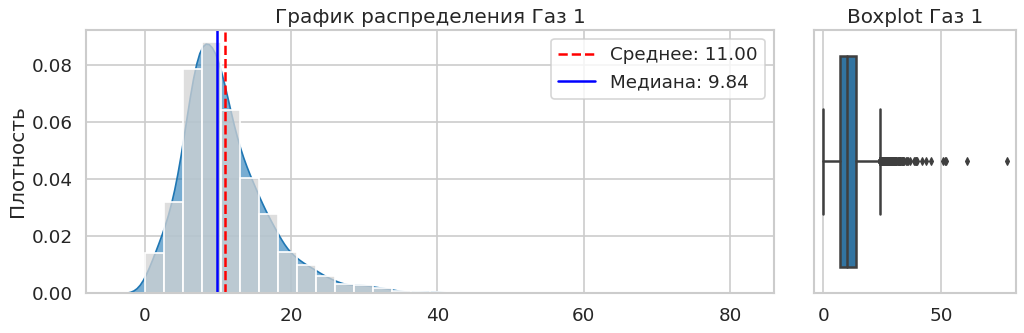

In [71]:
graph(datasets['data_gas'], 'Газ 1')

Выводы:

- **Анализ распределения**:

    - Распределение данных: 
        - По результатам анализа можно заключить, что распределение данных приближено к нормальному.

- **Качество данных**:

     - Дубликаты: 
        - Датасет не содержит дублированных записей.

- **Типы данных**: 
     - Все типы данных в датасете указаны корректно.

- **Пропущенные значения**: 
    - Пропущенные или незаполненные значения в датасете отсутствуют.


`data_temp_new.csv`:  Результаты измерения температуры.

In [72]:
analyze_data(datasets['data_temp'])

Базовая информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB

Первые 10 строк:


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0



Основные статистические показатели:


,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000



Кол-во дубликатов: 0


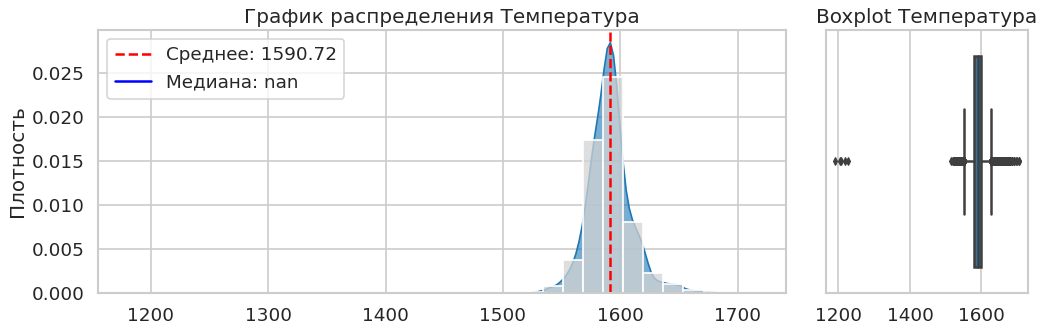

In [73]:
graph(datasets['data_temp'], 'Температура')

In [74]:
# Пропуски в столбце Температура
datasets['data_temp'][datasets['data_temp']['Температура'].isnull()].head(20)

,key,Время замера,Температура
13927,2500,2019-08-10 14:13:11,NaN
13928,2500,2019-08-10 14:18:12,NaN
13929,2500,2019-08-10 14:25:53,NaN
13930,2500,2019-08-10 14:29:39,NaN
13932,2501,2019-08-10 14:49:15,NaN
13933,2501,2019-08-10 15:02:56,NaN
13934,2501,2019-08-10 15:07:47,NaN
13935,2501,2019-08-10 15:16:53,NaN
13936,2501,2019-08-10 15:22:50,NaN
13937,2501,2019-08-10 15:29:00,NaN


In [75]:
# Изменим тип данных
datasets['data_temp']['Время замера'] = pd.to_datetime(datasets['data_temp']['Время замера'])


Выводы:

- **Обработка пропущенных данных**:

    - Пропуски по температурам: 
        - В датасете обнаружены пропуски по данным температуры. Для корректности анализа и обучения модели, такие строки были удалены.

- **Анализ распределения**:

    - Характер распределения: 
        - На основе анализа можно заключить, что распределение данных приближено к нормальному.

- **Аномалии**: 
    - В данных обнаружены аномальные выбросы, которые могут повлиять на анализ и моделирование.

- **Пропущенные значения**:

    - Пропуски начиная с 2500 партии: 
        - С 2500 партии в данных обнаружены пропущенные значения.

- **Корректировка типов данных**:

    - Время замера: 
        - Тип данных для столбца 'Время замера' был скорректирован на `datetime`.

- **Проверка на дубликаты**:

    - Дубликаты: 
        - Дублированные записи в датасете отсутствуют.


`data_wire_new.csv`:  Объемные данные о проволочных материалах.

In [76]:
analyze_data(datasets['data_wire'])

Базовая информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB

Первые 10 строк:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Основные статистические показатели:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604



Кол-во дубликатов: 0


 Выводы:

- **Проверка на дубликаты**:

    - Дубликаты: 
        - В датасете отсутствуют дублированные записи.

- **Анализ пропущенных данных**:

    - Пустые значения: 
        - В датасете присутствуют пустые значения. Возможная причина их появления заключается в том, что разные виды проволочных материалов поставлялись в разных пропорциях на протяжении различных временных интервалов.

- **Проверка корректности типов данных**:

    - Типы данных: 
        - Все столбцы датасета имеют корректно установленные типы данных.


`data_wire_time`:  Временные данные о проволочных материалах

In [77]:
analyze_data(datasets['data_wire_time'])

Базовая информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB

Первые 10 строк:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:57:27,2019-05-03 13:48:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:18:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:01:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:45:44,2019-05-03 15:39:37,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:27:00,2019-05-03 16:22:36,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Основные статистические показатели:


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000



Кол-во дубликатов: 0


In [78]:
# Все столбцы, которые содержат Wire в названии приведем к формату datetime
for column in datasets['data_wire_time'].columns:
    if 'Wire' in column:
        datasets['data_wire_time'][column] = pd.to_datetime(datasets['data_wire_time'][column])

Выводы
- **Проверка на дубликаты**:

    - Дубликаты: 
        - В датасете отсутствуют дублированные записи.

- **Анализ пропущенных данных**:

    - Пустые значения: 
        - В датасете присутствуют пустые значения. Возможная причина их появления заключается в том, что разные виды проволочных материалов поставлялись в разных пропорциях на протяжении различных временных интервалов.

- **Проверка корректности типов данных**:

    - Типы данных: 
        - Типы данных в Wire 1	Wire 2	Wire 3	Wire 4	Wire 5	Wire 6	Wire 7	Wire 8	Wire 9 указаны неверно.

# Вывод по Исследовательскому Анализу Данных

1. **Загрузка и первичное изучение данных**:  
   Данные были успешно загружены и подвергнуты первичному осмотру.

2. **Обработка аномальных значений**:  
   Некоторые аномальные значения были идентифицированы и успешно удалены.

3. **Коррекция типов данных**:  
   Типы данных в некоторых столбцах, особенно там, где ожидались даты и времена (`Datetime`), были скорректированы.

4. **Проверка на пропуски и дубликаты**:  
   Данные были проверены на наличие пропусков и дубликатов, и соответствующие корректировки были выполнены где это было необходимо.

5. **Добавление нового признака в `data_arc`**:  
   В датасете `data_arc` был добавлен новый признак "Полная мощность" для более глубокого анализа.

6. **Обнаружение отсутствующих данных в таргете**:  
   Заметили, что в целевой переменной (таргете) отсутствуют данные, начиная с 2500-й партии. В дальнейшем планируем провести срез данных, исключая партии после 2500.
7. Вопросов нет.

## Предобработка данных

**План дальнейших действий**

1. **Объединение таблиц**:  
   Планируем объединить все соответствующие таблицы в один общий датасет, который будет использоваться для нашей будущей модели.

2. **Целевой признак**:  
   На основе данных выбрали "Последняя температура" в качестве целевого признака для нашей модели.

3. **Срез данных**:  
   Чтобы улучшить качество данных для нашей модели, мы проведем срез данных по признаку `Key`, исключив данные начиная с 2500-й партии.


In [79]:
# Создаем новый признак "Общее время нагрева дугой", вычитая дату начала нагрева из даты конца нагрева
datasets['data_arc']['Общее время нагрева дугой'] = (datasets['data_arc']['Конец нагрева дугой'] - datasets['data_arc']['Начало нагрева дугой']).dt.seconds


In [80]:
# Ограничиваем данные до 2500 партии из-за отсутствия температурных значений после этой отметки

keys_to_include = 'key < 2500'

datasets['data_temp']  = datasets['data_temp'].query(keys_to_include)
datasets['data_arc'] = datasets['data_arc'].query(keys_to_include)
datasets['data_bulk'] = datasets['data_bulk'].query(keys_to_include)
datasets['data_wire'] = datasets['data_wire'].query(keys_to_include)

In [81]:
datasets['data_arc']

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность,Общее время нагрева дугой
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0.371123,228
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0.902319,185
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0.722536,172
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0.642824,365
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,1.079934,148
...,...,...,...,...,...,...,...
11444,2498,2019-08-10 13:20:18,2019-08-10 13:20:59,0.508786,0.363916,0.625538,41
11445,2499,2019-08-10 13:33:31,2019-08-10 13:38:43,0.700677,0.534767,0.881433,312
11446,2499,2019-08-10 13:41:44,2019-08-10 13:45:09,0.333776,0.269695,0.429117,205
11447,2499,2019-08-10 13:46:38,2019-08-10 13:51:33,0.406252,0.263303,0.484117,295


In [82]:
# Группировка данных для подсчёта количества попыток нагрева для каждого key (ковша)
data_arc_count = datasets['data_arc'].groupby('key').size().reset_index(name='Количество попыток нагрева')

# Группировка данных по ключу key с агрегацией суммой по остальным признакам
data_arc_grouped = datasets['data_arc'].groupby('key', as_index=False).sum()

# Объединение агрегированных таблиц data_arc_grouped и data_arc_c по ключу key
data_arc_final = data_arc_grouped.merge(data_arc_count, on='key')

# Оставляем только необходимые признаки в таблице и удаляем коррелирующие признаки активной и реактивной мощности
data_arc_final = data_arc_final[['key', 'Полная мощность', 'Общее время нагрева дугой', 'Количество попыток нагрева']]

data_arc_final.head(5)


,key,Полная мощность,Общее время нагрева дугой,Количество попыток нагрева
0,1,3.718736,1098,5
1,2,2.588349,811,4
2,3,5.019223,655,5
3,4,3.400038,741,4
4,5,2.816980,869,4


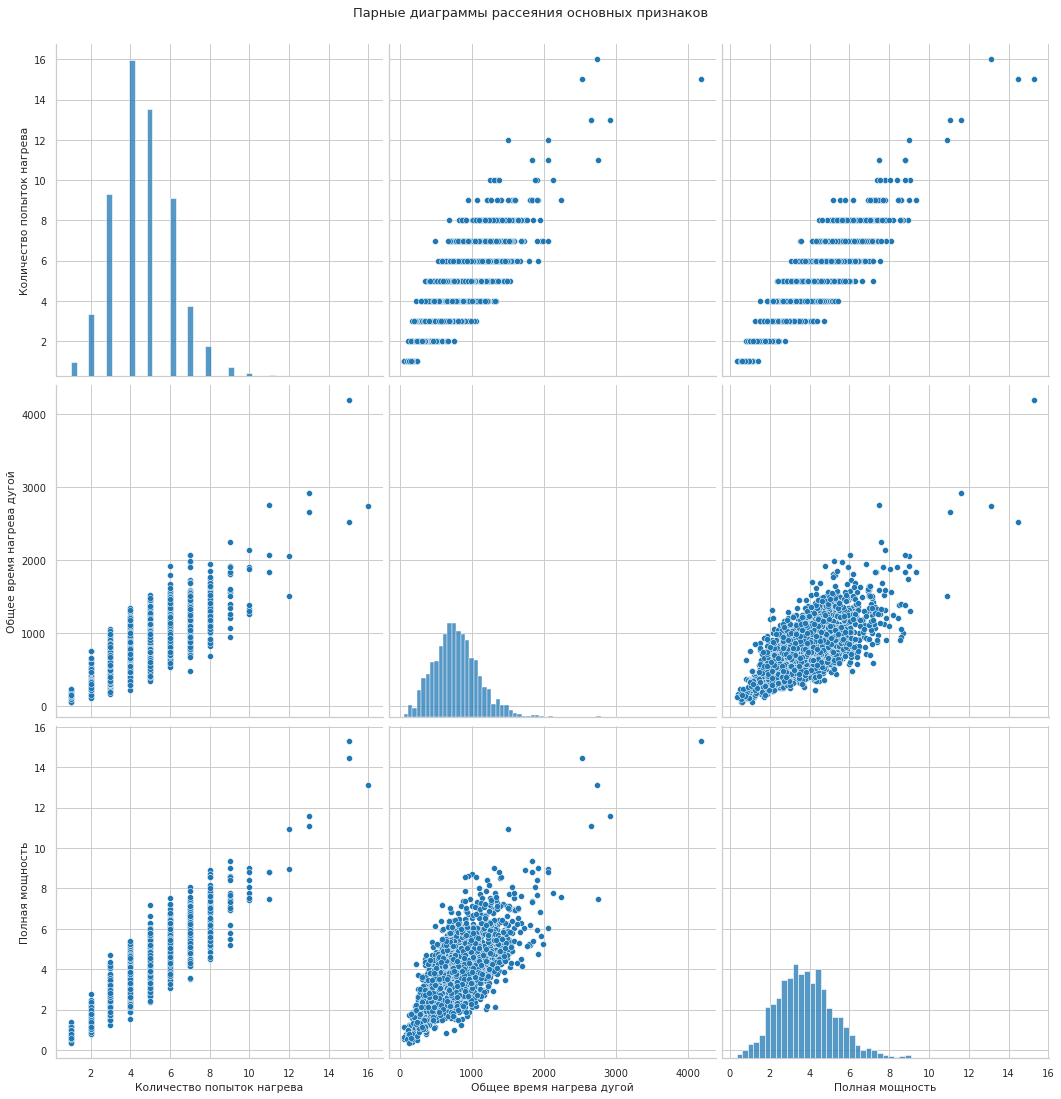

In [83]:
# Устанавливаем стиль и контекст для графиков
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=0.9)

# Выводим парные диаграммы рассеяния с установленным размером и палитрой
g = sns.pairplot(data_arc_final[['Количество попыток нагрева', 'Общее время нагрева дугой', 'Полная мощность']], 
                 kind="scatter", 
                 height=5, 
                 palette="tab10")

# Установим заголовок для всего графика
g.fig.suptitle("Парные диаграммы рассеяния основных признаков", y=1.02)

# Отображаем график
plt.show()


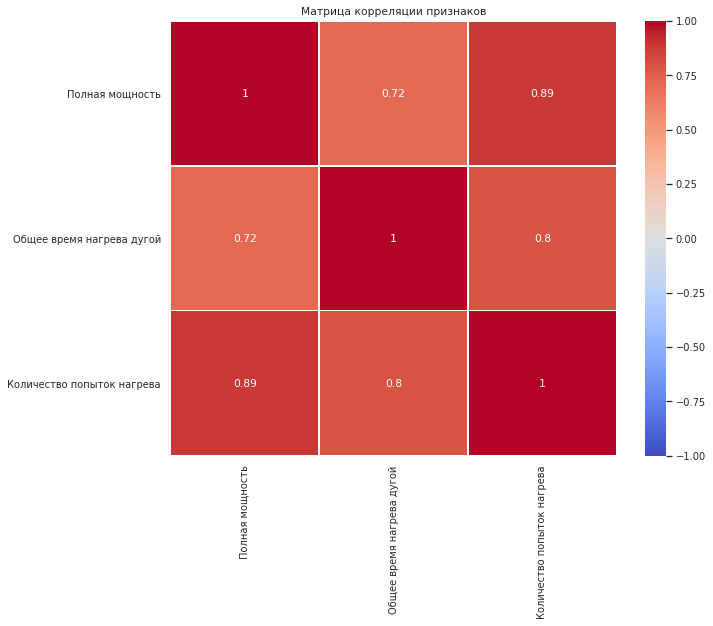

In [84]:
# Вычисляем матрицу корреляции
corr_matrix = data_arc_final[['Полная мощность', 'Общее время нагрева дугой', 'Количество попыток нагрева']].corr()

# Визуализируем корреляцию с помощью тепловой карты
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, linewidths=.5)
plt.title("Матрица корреляции признаков")
plt.show()

# Вывод
strong_corr_value = 0.7



In [85]:
data_arc_final

,key,Полная мощность,Общее время нагрева дугой,Количество попыток нагрева
0,1,3.718736,1098,5
1,2,2.588349,811,4
2,3,5.019223,655,5
3,4,3.400038,741,4
4,5,2.816980,869,4
...,...,...,...,...
2470,2495,3.868721,723,4
2471,2496,5.070316,940,6
2472,2497,4.360918,569,3
2473,2498,3.909917,750,5


In [86]:
# Удалим признак "количество попыток нагрева", так как он сильно коррелирует с полной мощностью
#data_arc_final = data_arc_final[['key', 'Полная мощность', 'Общее время нагрева дугой']]

`data_temp.csv`: обработаем датасет;

In [87]:
# Очистим пропуски в данных в таблице data_temp
datasets['data_temp'] = datasets['data_temp'].dropna(subset=['Температура']).reset_index(drop=True)

# Отсортируем данные по дате замера температуры
datasets['data_temp'] = datasets['data_temp'].sort_values(by=['Время замера'])

# Вычисляем количество измерений температуры для каждой партии
count_measurements = datasets['data_temp'].groupby('key').size()

# Получаем список партий, для которых доступно только одно измерение температуры
keys_with_one_measurement = count_measurements[count_measurements == 1].index.tolist()

# Удаляем записи с партиями, у которых только одно измерение температуры
datasets['data_temp'] = datasets['data_temp'][~datasets['data_temp']['key'].isin(keys_with_one_measurement)]

# Группировка данных по партии для получения первого и последнего значения температуры
data_temp_grouped = datasets['data_temp'].groupby('key').agg(Температура_начало=('Температура', 'first'),
                                                 Температура_конец=('Температура', 'last')).reset_index()

# Результат: датафрейм с первым и последним значениями температуры для каждой партии
print(data_temp_grouped)

       key  Температура_начало  Температура_конец
0        1              1571.0             1613.0
1        2              1581.0             1602.0
2        3              1596.0             1599.0
3        4              1601.0             1625.0
4        5              1576.0             1602.0
...    ...                 ...                ...
2470  2495              1570.0             1591.0
2471  2496              1554.0             1591.0
2472  2497              1571.0             1589.0
2473  2498              1591.0             1594.0
2474  2499              1569.0             1603.0

[2475 rows x 3 columns]


In [88]:
# объединим датасеты по ключу key
data_full = (data_temp_grouped.merge(data_arc_final, how = 'inner', on = 'key')
                 .merge(datasets['data_wire'], how = 'inner', on = 'key')
                 .merge(datasets['data_bulk'], how = 'inner', on = 'key')
                 .merge(datasets['data_gas'], how = 'inner', on = 'key')
       )


# заполним пропуски образовавшиеся после объединения таблиц нулями
data_full = data_full.fillna(0)

data_full = data_full.drop(['key'], axis = 1)

In [89]:
# объединил по inner, добавил комментарии. Выводы ниже

<font color='blue'><b>Комментарий тимлида v2</b>
<br> Просмотр данные не анализ - не понятно, какие получились распределения признаков после объдинения, которое забирает часть партий. Плюс изучение корреляций может найти высокоскореллированные признаки и учесть эффект мультиколлинеарности при выборе моделей https://www.codecamp.ru/blog/multicollinearity-regression/
</font><strike>

In [90]:
data_full.head()


,Температура_начало,Температура_конец,Полная мощность,Общее время нагрева дугой,Количество попыток нагрева,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,...,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Газ 1
0,1571.0,1613.0,3.718736,1098,5,60.059998,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986
1,1581.0,1602.0,2.588349,811,4,96.052315,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561
2,1596.0,1599.0,5.019223,655,5,91.160157,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793
3,1601.0,1625.0,3.400038,741,4,89.063515,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219
4,1576.0,1602.0,2.816980,869,4,89.238236,9.11456,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692


In [91]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Температура_начало          2329 non-null   float64
 1   Температура_конец           2329 non-null   float64
 2   Полная мощность             2329 non-null   float64
 3   Общее время нагрева дугой   2329 non-null   int64  
 4   Количество попыток нагрева  2329 non-null   int64  
 5   Wire 1                      2329 non-null   float64
 6   Wire 2                      2329 non-null   float64
 7   Wire 3                      2329 non-null   float64
 8   Wire 4                      2329 non-null   float64
 9   Wire 5                      2329 non-null   float64
 10  Wire 6                      2329 non-null   float64
 11  Wire 7                      2329 non-null   float64
 12  Wire 8                      2329 non-null   float64
 13  Wire 9                      2329 

- Для вычисления VIF (коэффициент инфляции дисперсии) можно воспользоваться библиотекой statsmodels. VIF измеряет, насколько дисперсия коэффициента увеличивается, когда предикторы коррелируют. Если VIF больше 5-10, это означает, что существует проблема мультиколлинеарности.

In [92]:
# Уберем целевую переменную из данных
features = data_full.drop("Температура_конец", axis=1)

# Вычисление VIF для каждого признака
vif_data = pd.DataFrame()
vif_data["Feature"] = features.columns
vif_data["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]

print(vif_data)

                       Feature        VIF
0           Температура_начало  16.761193
1              Полная мощность  34.740933
2    Общее время нагрева дугой  24.168791
3   Количество попыток нагрева  60.710030
4                       Wire 1   8.995864
5                       Wire 2   1.554444
6                       Wire 3   1.142406
7                       Wire 4   3.469455
8                       Wire 5        NaN
9                       Wire 6   1.533245
10                      Wire 7   1.625146
11                      Wire 8  57.192080
12                      Wire 9   1.072382
13                      Bulk 1   1.476494
14                      Bulk 2   2.872972
15                      Bulk 3   1.622509
16                      Bulk 4   1.998749
17                      Bulk 5   1.185181
18                      Bulk 6   1.519340
19                      Bulk 7   2.731421
20                      Bulk 8   3.723771
21                      Bulk 9  67.731391
22                     Bulk 10   1

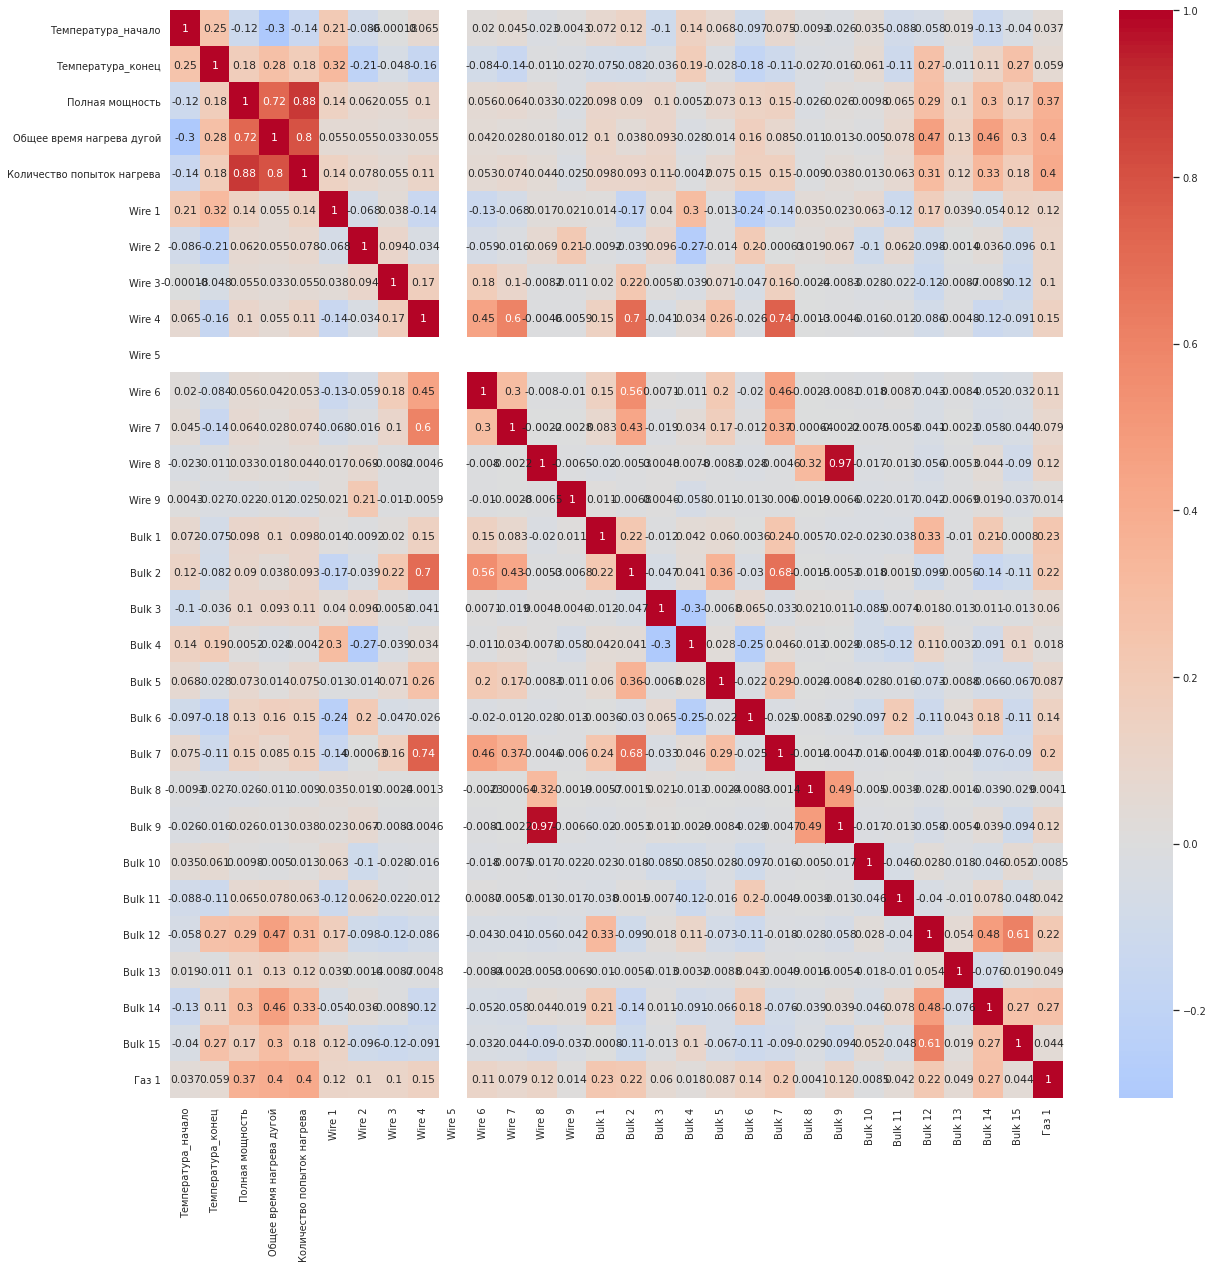

In [93]:
corr_matrix = data_full.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.show()

In [94]:
#data_full = data_full.drop(['Температура_начало','Общее время нагрева дугой', 'Количество попыток нагрева', 'Wire 1','Wire 5','Wire 8','Bulk 9','Bulk 12', 'Bulk 14','Газ 1'], axis = 1)

#Уберем кореллированные признаки из данных
data_full = data_full.drop(['Количество попыток нагрева', 'Wire 5', 'Wire 8','Bulk 9'], axis = 1)

In [95]:
# Уберем целевую переменную из данных
features = data_full.drop("Температура_конец", axis=1)

# Вычисление VIF для каждого признака
vif_data = pd.DataFrame()
vif_data["Feature"] = features.columns
vif_data["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]

print(vif_data)

                      Feature        VIF
0          Температура_начало  15.746453
1             Полная мощность  16.901652
2   Общее время нагрева дугой  18.587320
3                      Wire 1   8.917950
4                      Wire 2   1.545098
5                      Wire 3   1.139250
6                      Wire 4   3.469007
7                      Wire 6   1.532002
8                      Wire 7   1.624056
9                      Wire 9   1.070133
10                     Bulk 1   1.472817
11                     Bulk 2   2.872675
12                     Bulk 3   1.621200
13                     Bulk 4   1.989548
14                     Bulk 5   1.183786
15                     Bulk 6   1.504872
16                     Bulk 7   2.725643
17                     Bulk 8   1.006442
18                    Bulk 10   1.135830
19                    Bulk 11   1.101780
20                    Bulk 12   7.410836
21                    Bulk 13   1.060191
22                    Bulk 14   7.786679
23              

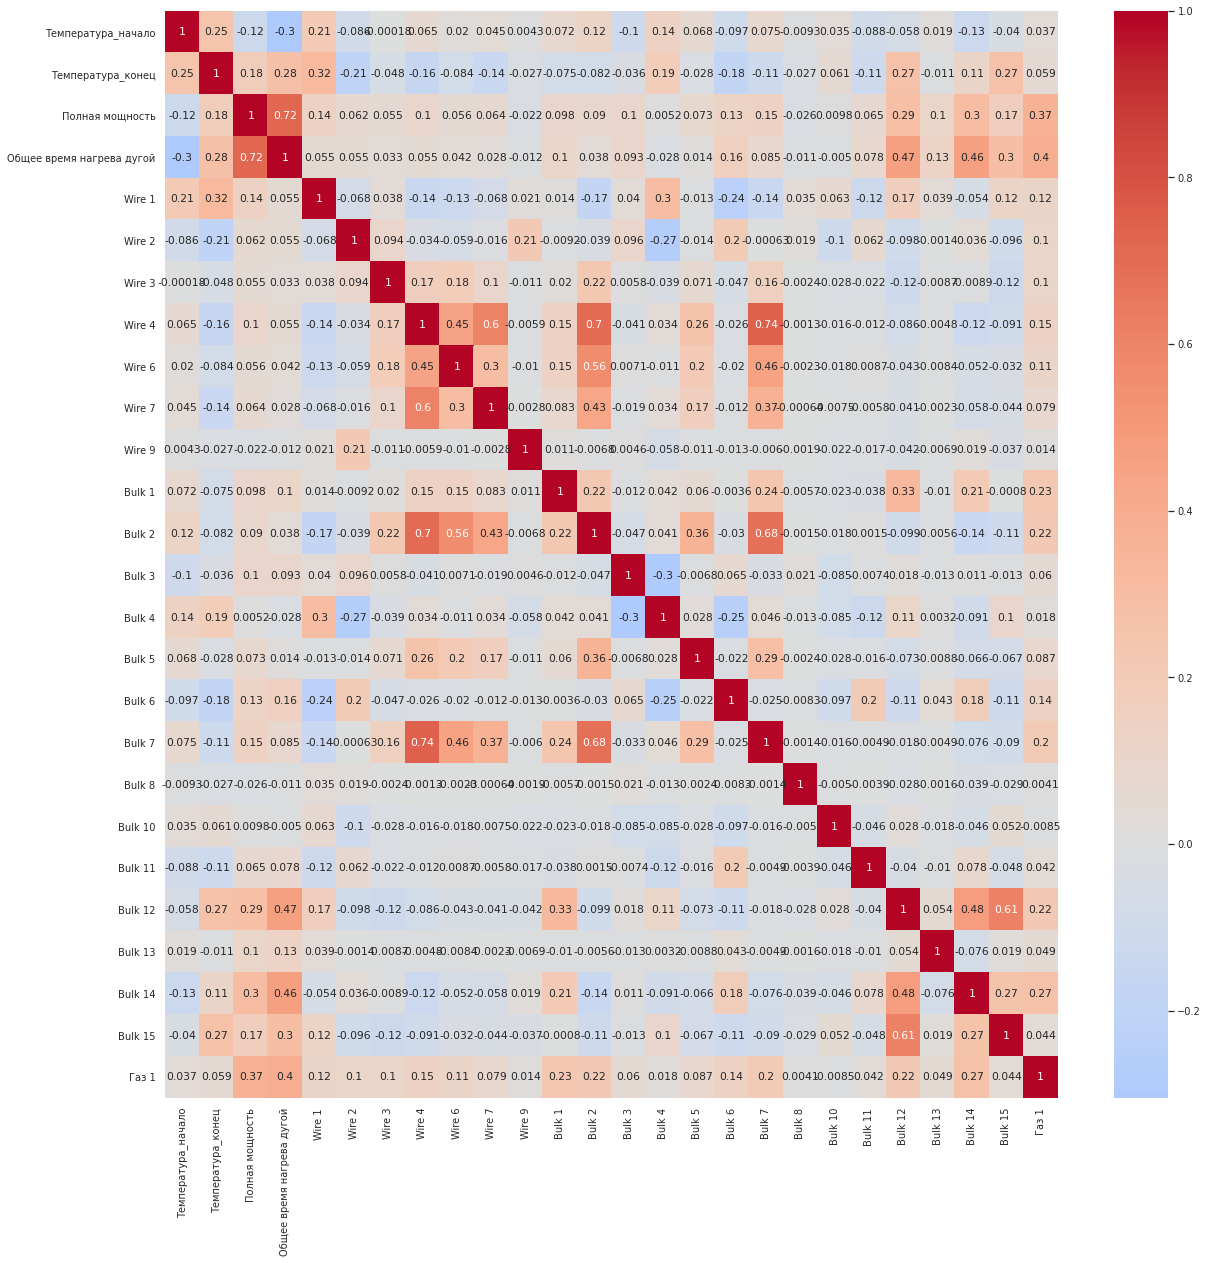

In [96]:
corr_matrix = data_full.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.show()

- Удалили кореллированные признаки  'Количество попыток нагрева', 'Wire 5', 'Wire 8','Bulk 9'
- Обработка выбросов — важный этап предварительной обработки данных перед обучением модели машинного обучения. Выбросы могут искажать результаты модели, делая её менее стабильной или уменьшая её производительность.

- Температура_Начало, Полная мощность, Общее время нагрева дугой, Wire 1, Газ 1 - Распределены нормально


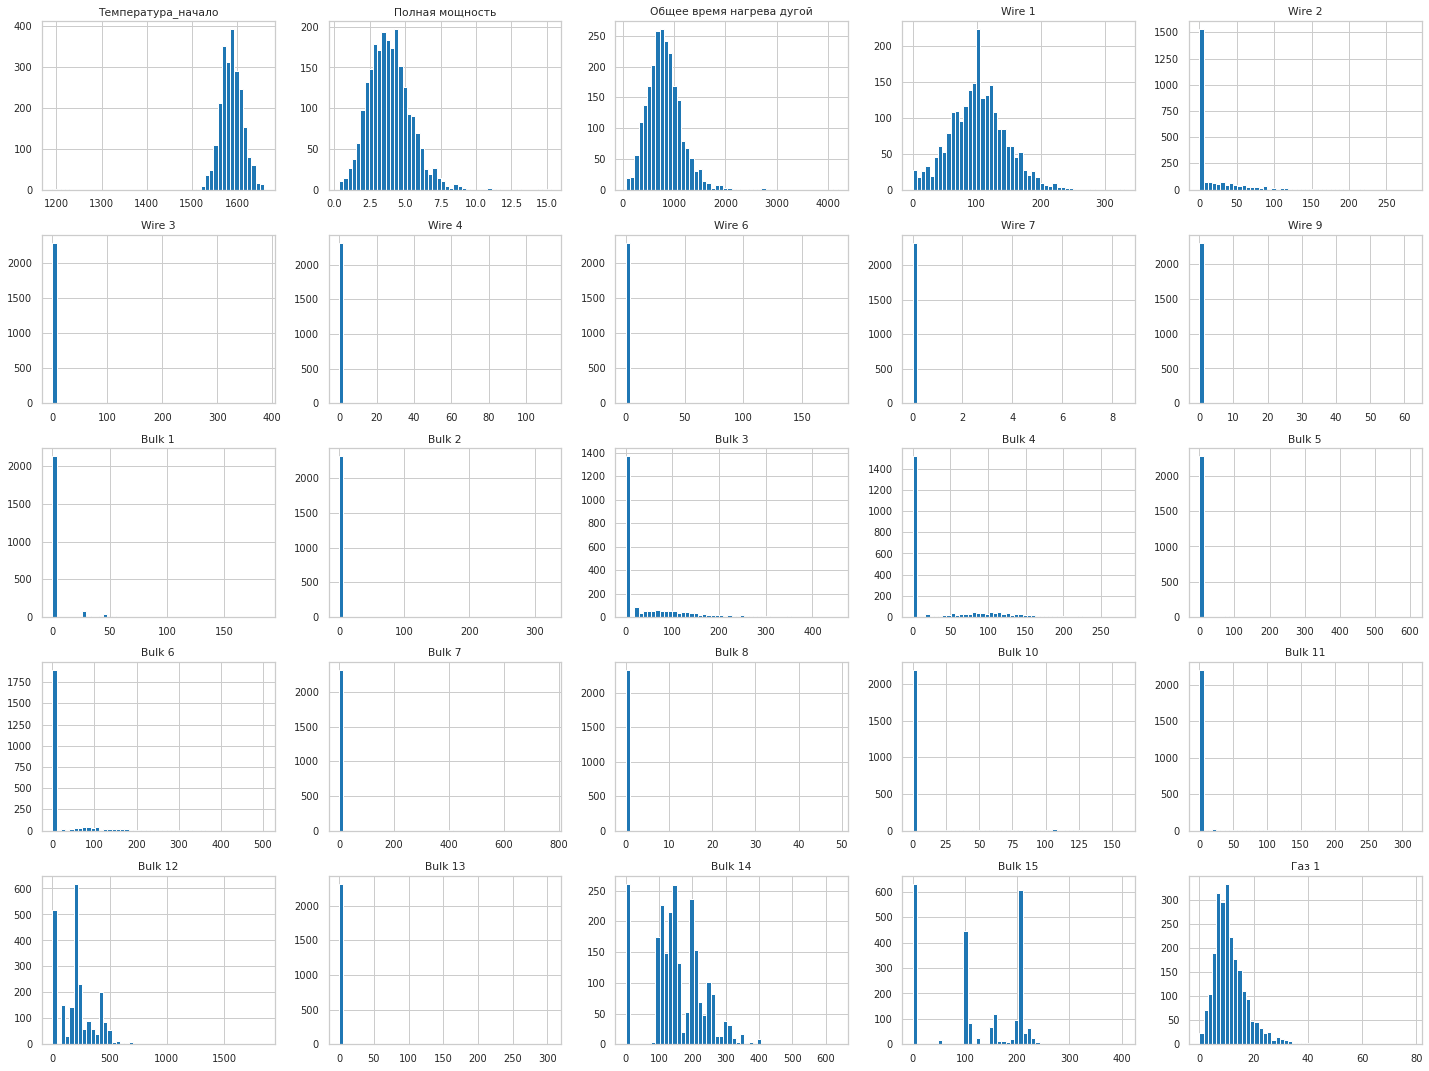

In [97]:
# Построим гистограммы
data_full.drop('Температура_конец', axis=1).hist(figsize=(20, 15), bins=50)
plt.tight_layout()
plt.show()

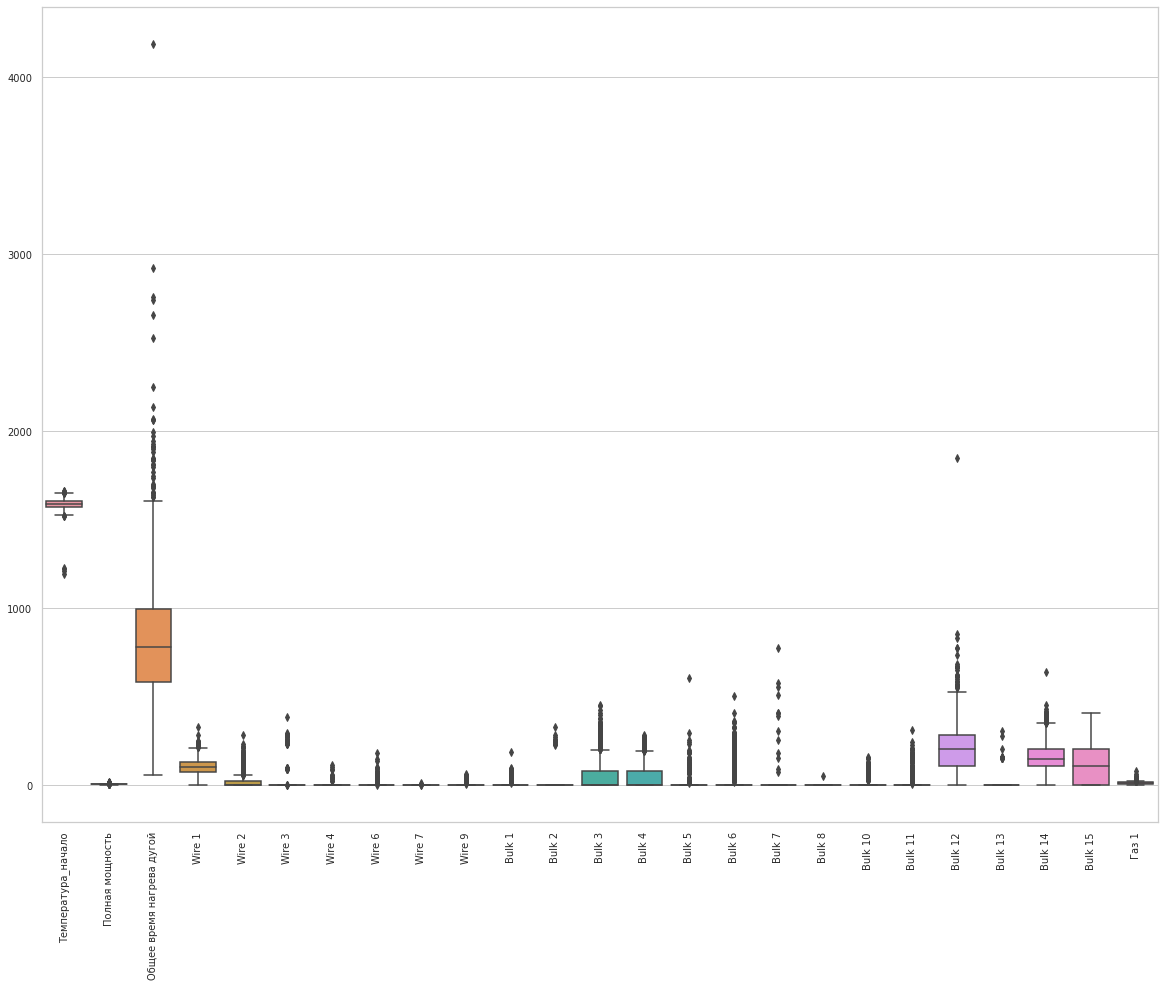

In [98]:
plt.figure(figsize=(20, 15))
sns.boxplot(data=data_full.drop('Температура_конец', axis=1))
plt.xticks(rotation=90)
plt.show()

In [99]:
# # Удалим выбросы
# for column in data_full.columns:
#     Q1 = data_full[column].quantile(0.25)
#     Q3 = data_full[column].quantile(0.75)
#     IQR = Q3 - Q1
    
#     lower_bound = Q1 - 3 * IQR
#     upper_bound = Q3 + 3 * IQR
    
#     data_full = data_full[(data_full[column] >= lower_bound) & (data_full[column] <= upper_bound)]

In [100]:
# plt.figure(figsize=(20, 15))
# sns.boxplot(data=data_full.drop('Температура_конец', axis=1))
# plt.xticks(rotation=90)
# plt.show()

In [101]:
# Предполагая, что Температура_конец - это целевая переменная
X = data_full.drop('Температура_конец', axis=1) # Признаки
y = data_full['Температура_конец'] # Целевая переменная

# Разделение данных на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=random_state)

# Масштабирование признаков
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train) # Обучение и преобразование тренировочного набора данных
X_test_scaled = scaler.transform(X_test) # Преобразование тестового набора данных

<font color='blue'><b>Комментарий тимлида v4</b></font><strike>
<br><font color='crimson'> ❌ Деление выборок 3:1 или 75:25

Вывод по предобработке данных

В ходе выполнения работы по предобработке данных был проделан следующий объем работы:

 1. **Обработка данных:** 
   - Был проведен анализ исходных данных на наличие аномалий, несоответствующих значений и других потенциальных проблем.
   - В результате анализа была выполнена коррекция и очистка данных, что обеспечило надежную основу для дальнейшего анализа.

 2. **Обработка выбросов и пропусков:** 
   - Удалены аномальные значения, которые могли бы исказить результаты анализа.
   - Обнаруженные пропущенные значения были корректно заполнены или удалены, чтобы обеспечить целостность данных.

 3. **Слияние таблиц:** 
   - Для обеспечения удобства работы и анализа исходные таблицы были объединены в одну итоговую таблицу.
 4. **Проверка на мультиколлениарность** 
   - Удалил признак "количество попыток нагрева", так как он сильно коррелирует с полной мощностью

 5. **Разделение данных:** 
   - Данные были разделены на обучающую и тестовую выборки в соотношении 70% к 30% соответственно. Это позволяет обучить модель на большем объеме данных и проверить ее эффективность на тестовой выборке.

 6. **Масштабирование признаков:** 
   - С учетом того, что алгоритмы машинного обучения чувствительны к различиям в масштабе признаков, было выполнено их масштабирование. Это позволяет улучшить качество обучения модели и делает результаты анализа более надежными.


# 3. Обучение моделей 

In [102]:
# # Функция для обучения моделей и оценки результатов
# def fit(train_features, train_actuals, test_features, test_actuals, models, params):
#     """
#     Обучает модели с использованием GridSearchCV, предсказывает значения для тренировочного и тестового наборов данных
#     и сохраняет результаты в список.

#     Параметры:
#         - train_features: признаки тренировочного набора данных
#         - train_actuals: истинные значения тренировочного набора данных
#         - test_features: признаки тестового набора данных
#         - test_actuals: истинные значения тестового набора данных
#         - models: словарь с именами моделей и их экземплярами
#         - params: словарь с именами моделей и их гиперпараметрами для GridSearchCV
#     """
    
#     results = []
    
#     # Итерация по каждой модели с использованием tqdm для отображения прогресс-бара
#     for name, estimator in tqdm(models.items(), desc="Training models"):
#         # GridSearchCV для подбора оптимальных параметров
#         gscv = GridSearchCV(estimator=estimator, param_grid=params[name], cv=5, n_jobs=-1)
#         gscv.fit(train_features, train_actuals)
        
#         # Получение предсказаний для тренировочного наборов данных
#         train_predictions = gscv.predict(train_features)
#        # test_predictions = gscv.predict(test_features)
        
#         # Сохранение результатов
#         results.append({
#             'model': name,
#             'train_mae_score': mean_absolute_error(train_actuals, train_predictions),
#             #'test_mae_score': mean_absolute_error(test_actuals, test_predictions),
#             'best_params': gscv.best_params_
#         })
        
#     return results

In [103]:
def fit(train_features, train_actuals, models, params):
    """
    Обучает модели с использованием GridSearchCV, предсказывает значения для тренировочного и тестового наборов данных
    и сохраняет результаты в список.

    Параметры:
        - train_features: признаки тренировочного набора данных
        - train_actuals: истинные значения тренировочного набора данных
        - models: словарь с именами моделей и их экземплярами
        - params: словарь с именами моделей и их гиперпараметрами для GridSearchCV
    """
    results = []
    best_estimators = {}  # Словарь для хранения экземпляров GridSearchCV
    
    # Итерация по каждой модели
    for name, estimator in tqdm(models.items(), desc="Training models"):
        gscv = GridSearchCV(estimator=estimator, param_grid=params[name], cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')
        gscv.fit(train_features, train_actuals)
        
        train_predictions = gscv.predict(train_features)
        scores = cross_val_score(estimator, train_features, train_actuals, cv=5, scoring='neg_mean_absolute_error')
        average_score = scores.mean()
        print(f"Model: {name}, Average MAE: {-average_score}")  # Используем отрицательное значение, так как 'neg_mean_absolute_error' возвращает отрицательные значения
        results.append({
            'model': name,
            'train_mae_score': mean_absolute_error(train_actuals, train_predictions),
            'cv_mae_score': -gscv.best_score_,  # Здесь мы берем отрицательное значение, потому что используем 'neg_mean_absolute_error' в качестве метрики
            'best_params': gscv.best_params_
        })

        best_estimators[name] = gscv
        
    return results, best_estimators

- переписал функцию fit(старая закомментирована выше). В новой функции удалил строки с проверкой на тестовых данных.
- сделал отдельную функцию для тестирования на кроссвалидационных параметрах
- добавил scoring='neg_mean_absolute_error' в GridSearchCV

<font color='blue'><b>Комментарий тимлида</b></font><strike>
<br><font color='crimson'> ❌ Только одна лучшая модель должна получать доступ к тестовым данным
<br><font color='crimson'> ❌ В GridSearchCV лежит метрика по кросс-валидации. Мтерика на обчучении не дает нам понимания о качестве модели на новых данных

- Ниже написана функция evaluate_on_test_data где берется best_estimator_ и лучшая модель проверяется на тестовых данных

<font color='blue'><b>Комментарий тимлида v2</b>
<br> 'train_mae_score': mean_absolute_error(train_actuals, train_predictions) - это метрика на обучающей выборке, зная обучающую выборку. Из GridSearchCV нужно получить лучшую метрику на кросс валидации по нужному скорингу: 1) выставить в параметры GridSearchCV метрику MAE и 2) В атрибуте gscv кранится лучший результат таблицы
 </font><strike>

<font color='blue'><b>Комментарий тимлида v3</b></font><strike>
<br><font color='crimson'> ❌ Сделай упражнение "провести кросс-валидацию без поиска гиперпараметров" на cross_val_score(), чтобы понять, какая метрика должна получаться, и в документации https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html найти Атрибут GridSearchCV, который отвечает за среднюю метрику на кросс-валидации. mean_absolute_error(train_actuals, train_predictions) - это не метрика на кросс-валидации

In [52]:
models = {    
    'LinearRegression': LinearRegression(),
    'LGBMRegressor': lgb.LGBMRegressor(),
    'XGBRegressor': xgboost.XGBRegressor(),
    'CatBoostRegressor': CatBoostRegressor(verbose=0)  
}

params = {
    'CatBoostRegressor': {
        'iterations': [500, 1000, 1500],
        'learning_rate': [0.01, 0.03, 0.1, 0.3],
        'depth': [8, 9, 10],
        'l2_leaf_reg': [1, 5, 10],
        'loss_function':['MAE'],
        'random_seed': [random_state]

    },
    'LGBMRegressor': {
        'num_leaves': [70,80],
        'min_data_in_leaf': [20, 30, 40],
        'max_depth': [4, 7, 10],
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [100, 500, 1000],
         'num_iterations':[500, 1000, 1500],
        'metric': ['mae'],
        'random_state':[random_state]
    },
    'XGBRegressor': {
        'max_depth': [3, 6, 9,12,15],
        'min_child_weight': [1, 5, 10],
        'gamma': [0, 0.2, 0.5, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [100, 500, 1000],
        'eval_metric': ['mae'],
        'random_state':[random_state]
    },
    'LinearRegression': {
        'fit_intercept': [True, False],
        'copy_X': [True, False],
        'positive': [True, False]
    }
}


- Запуск кода ниже может 2 часа занимать

In [53]:
def cross_val_models(X_train_scaled, y_train, models):
    """
    Проводит кросс-валидацию для каждой модели без оптимизации гиперпараметров.

    Параметры:
        - train_features: признаки тренировочного набора данных
        - train_actuals: истинные значения тренировочного набора данных
        - models: словарь с именами моделей и их экземплярами
    """

    results = []

    for name, estimator in models.items():
        # Применяем кросс-валидацию
        scores = cross_val_score(estimator, X_train_scaled, y_train, cv=5, scoring='neg_mean_absolute_error')
        average_score = scores.mean()
        
        results.append({
            'model': name,
            'cv_mae_score': -average_score  # Используем отрицательное значение, так как 'neg_mean_absolute_error' возвращает отрицательные значения
        })

    return results


results = cross_val_models(X_train_scaled, y_train, models)
for res in results:
    print(f"Model: {res['model']}, Average CV MAE: {res['cv_mae_score']}")

Model: LinearRegression, Average CV MAE: 6.521605596806056
Model: LGBMRegressor, Average CV MAE: 6.326733601197224
Model: XGBRegressor, Average CV MAE: 6.663629689738539
Model: CatBoostRegressor, Average CV MAE: 6.171393959856745


In [54]:
result_list, best_gscv_models = fit(X_train_scaled, y_train, models, params)

Training models:   0%|          | 0/4 [00:00<?, ?it/s]

Model: LinearRegression, Average MAE: 6.521605596806056


/Users/ksenia/anaconda3/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/ksenia/anaconda3/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/ksenia/anaconda3/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/ksenia/anaconda3/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/ksenia/anaconda3/lib/python3.10/site-packages/lightgbm/en

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min

/Users/ksenia/anaconda3/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/ksenia/anaconda3/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/ksenia/anaconda3/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/ksenia/anaconda3/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/ksenia/anaconda3/lib/python3.10/site-packages/lightgbm/en

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min

/Users/ksenia/anaconda3/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/ksenia/anaconda3/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/ksenia/anaconda3/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/ksenia/anaconda3/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/ksenia/anaconda3/lib/python3.10/site-packages/lightgbm/en

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min

/Users/ksenia/anaconda3/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/ksenia/anaconda3/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/ksenia/anaconda3/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min

/Users/ksenia/anaconda3/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/ksenia/anaconda3/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/ksenia/anaconda3/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


af=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warnin

/Users/ksenia/anaconda3/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/ksenia/anaconda3/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/ksenia/anaconda3/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/ksenia/anaconda3/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/ksenia/anaconda3/lib/python3.10/site-packages/lightgbm/en

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min

/Users/ksenia/anaconda3/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/ksenia/anaconda3/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/ksenia/anaconda3/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/ksenia/anaconda3/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/ksenia/anaconda3/lib/python3.10/site-packages/lightgbm/en

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min

/Users/ksenia/anaconda3/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/ksenia/anaconda3/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/ksenia/anaconda3/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/ksenia/anaconda3/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/ksenia/anaconda3/lib/python3.10/site-packages/lightgbm/en

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min

/Users/ksenia/anaconda3/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/ksenia/anaconda3/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/ksenia/anaconda3/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/ksenia/anaconda3/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/ksenia/anaconda3/lib/python3.10/site-packages/lightgbm/en

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min

/Users/ksenia/anaconda3/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/ksenia/anaconda3/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/ksenia/anaconda3/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/ksenia/anaconda3/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/ksenia/anaconda3/lib/python3.10/site-packages/lightgbm/en

=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=2

/Users/ksenia/anaconda3/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/ksenia/anaconda3/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/ksenia/anaconda3/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/ksenia/anaconda3/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/ksenia/anaconda3/lib/python3.10/site-packages/lightgbm/en

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
Model: LGBMRegressor, Average MAE: 6.326733601197224
Model: XGBRegressor, Average MAE: 6.663629689738539
Model: CatBoostRegressor, Average MAE: 6.171393959856745


In [55]:
#выведем параметры
result_list

[{'model': 'LinearRegression',
  'train_mae_score': 6.357810111565039,
  'cv_mae_score': 6.521605596806056,
  'best_params': {'copy_X': True, 'fit_intercept': True, 'positive': False}},
 {'model': 'LGBMRegressor',
  'train_mae_score': 4.241670229598015,
  'cv_mae_score': 6.210795868728197,
  'best_params': {'learning_rate': 0.01,
   'max_depth': 10,
   'metric': 'mae',
   'min_data_in_leaf': 30,
   'n_estimators': 100,
   'num_iterations': 500,
   'num_leaves': 70,
   'random_state': 140823}},
 {'model': 'XGBRegressor',
  'train_mae_score': 3.4971707093893185,
  'cv_mae_score': 6.025889338639736,
  'best_params': {'colsample_bytree': 1.0,
   'eval_metric': 'mae',
   'gamma': 0.5,
   'learning_rate': 0.01,
   'max_depth': 6,
   'min_child_weight': 1,
   'n_estimators': 1000,
   'random_state': 140823,
   'subsample': 0.8}},
 {'model': 'CatBoostRegressor',
  'train_mae_score': 3.167190481251561,
  'cv_mae_score': 6.177609586301964,
  'best_params': {'depth': 8,
   'iterations': 1500,
   

In [56]:
# Сохраним в таблиццу
results = pd.DataFrame(result_list, columns=['model','train_mae_score','cv_mae_score','best_params'])
results.set_index("model", inplace = True)

In [57]:
results

,train_mae_score,cv_mae_score,best_params
model,,,
LinearRegression,6.357810,6.521606,"{'copy_X': True, 'fit_intercept': True, 'posit..."
LGBMRegressor,4.241670,6.210796,"{'learning_rate': 0.01, 'max_depth': 10, 'metr..."
XGBRegressor,3.497171,6.025889,"{'colsample_bytree': 1.0, 'eval_metric': 'mae'..."
CatBoostRegressor,3.167190,6.177610,"{'depth': 8, 'iterations': 1500, 'l2_leaf_reg'..."


In [58]:
# Тестируем лучшую модель 

In [71]:
best_gscv_models['XGBRegressor']

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'eval_metric': ['mae'], 'gamma': [0, 0.2, 0.5, 5],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 6, 9, 12, 15],
                         'min_child_weight': [1, 5, 10],
                         'n_estimators': [100, 500, 1000],
                         'random_state': [140823],
                         'subsample': [0.6, 0.8, 1.0]},
             scoring='neg_mean_absolute_error')

In [67]:
def evaluate_on_test_data(model, test_features, test_actuals):
    test_predictions = model.predict(test_features)
    return mean_absolute_error(test_actuals, test_predictions), model

# Протестируем на тестовых данных CatBoostRegressor:
mae_score, model = evaluate_on_test_data(best_gscv_models['XGBRegressor'].best_estimator_, X_test_scaled, y_test)
print(f"MAE on test data for XGBRegressor: {mae_score}")

MAE on test data for XGBRegressor: 6.0966466049796315


In [68]:
best_gscv_models['XGBRegressor'].best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='mae', feature_types=None,
             gamma=0.5, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=140823, ...)

In [104]:
# КОД ТИМЛИДА
params = {'colsample_bytree': 1.0,
   'eval_metric': 'mae',
   'gamma': 0.5,
   'learning_rate': 0.01,
   'max_depth': 6,
   'min_child_weight': 1,
   'n_estimators': 1000,
   'random_state': 140823,
   'subsample': 0.8}

model = xgboost.XGBRegressor()
model.fit(X_train_scaled, y_train)
test_predictions = model.predict(X_test_scaled)
mean_absolute_error(y_test, test_predictions)

6.501530380641617

- добавил в код выше и в словаре params с параметрами моделей
'random_state':random_state

<font color='blue'><b>Комментарий тимлида v4</b></font><strike>
<br><font color='crimson'> ❌ В каждой модели, где требуется random_state, должен стоять это параметр

- Наименьшее МАЕ на обучающихся  данных удалось достичь модели XGBRegressor - 6.07:

[- 1.{'model': 'LinearRegression',
  'train_mae_score': 6.312786093831369,
  'best_params': {'copy_X': True, 'fit_intercept': True, 'positive': False}},
 - 2.{'model': 'LGBMRegressor',
  'train_mae_score': 4.676977784522815,
  'best_params': {'learning_rate': 0.01,
   'max_depth': 7,
   'metric': 'mae',
   'min_data_in_leaf': 30,
   'n_estimators': 100,
   'num_iterations': 500,
   'num_leaves': 70}},
 - 3.{'model': 'XGBRegressor',
  'train_mae_score': 1.078445977521089,
  'best_params': {'colsample_bytree': 1.0,
   'eval_metric': 'mae',
   'gamma': 0.5,
   'learning_rate': 0.01,
   'max_depth': 12,
   'min_child_weight': 1,
   'n_estimators': 1000,
   'subsample': 0.8}},
 - 4.{'model': 'CatBoostRegressor',
  'train_mae_score': 3.0473528322559043,
  'best_params': {'depth': 8,
   'iterations': 1500,
   'l2_leaf_reg': 10,
   'learning_rate': 0.01,
   'loss_function': 'MAE'}}]


MAE на тестовых данных для CatBoostRegressor: 6.099724063514653



In [62]:
results.values[0]

array([6.357810111565039, 6.521605596806056,
       {'copy_X': True, 'fit_intercept': True, 'positive': False}],
      dtype=object)

In [63]:
#  Полученные данные
values = [
    results.values[0],
    results.values[1],
    results.values[2],
    results.values[3]
 ]

columns = ['train_mae_score', 'cv_mae_score', 'best_params']
index = ['LinearRegression', 'LGBMRegressor', 'XGBRegressor', 'CatBoostRegressor']

# Создание DataFrame с заданным индексом
results_copy = pd.DataFrame(values, columns=columns, index=index)

# Добавляем имя индекса
results_copy.index.name = 'model'

In [64]:
# Результат подбора параметров
results_copy

,train_mae_score,cv_mae_score,best_params
model,,,
LinearRegression,6.357810,6.521606,"{'copy_X': True, 'fit_intercept': True, 'posit..."
LGBMRegressor,4.241670,6.210796,"{'learning_rate': 0.01, 'max_depth': 10, 'metr..."
XGBRegressor,3.497171,6.025889,"{'colsample_bytree': 1.0, 'eval_metric': 'mae'..."
CatBoostRegressor,3.167190,6.177610,"{'depth': 8, 'iterations': 1500, 'l2_leaf_reg'..."


<Figure size 3000x1000 with 0 Axes>

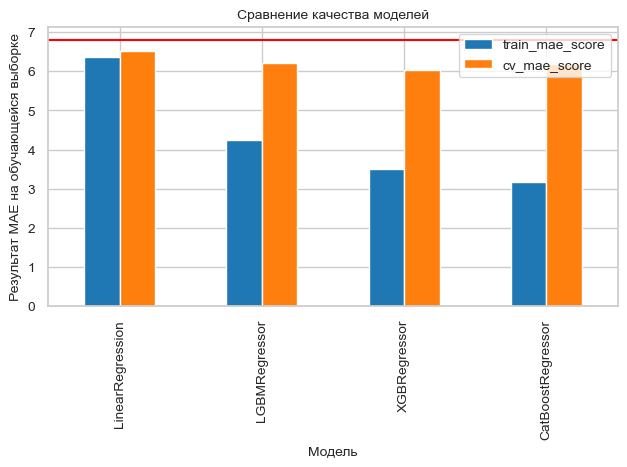

In [65]:
# Задаем размеры графика
plt.figure(figsize=(30, 10))

# Построение графика типа 'bar' для нашей таблицы results_copy
ax = results_copy.plot(kind='bar')

# Добавляем горизонтальную линию на уровне 6.8 - целевое значение
ax.hlines(6.8, -1, 5, color='r')

# Задаем подписи осей и заголовок графика
plt.xlabel('Модель', fontsize=10)
plt.ylabel('Результат MAE на обучающейся выборке', fontsize=10)
plt.title('Сравнение качества моделей', fontsize=10)

# Адаптируем расположение элементов графика, чтобы они не перекрывались
plt.tight_layout()

# Отображаем график
plt.show()

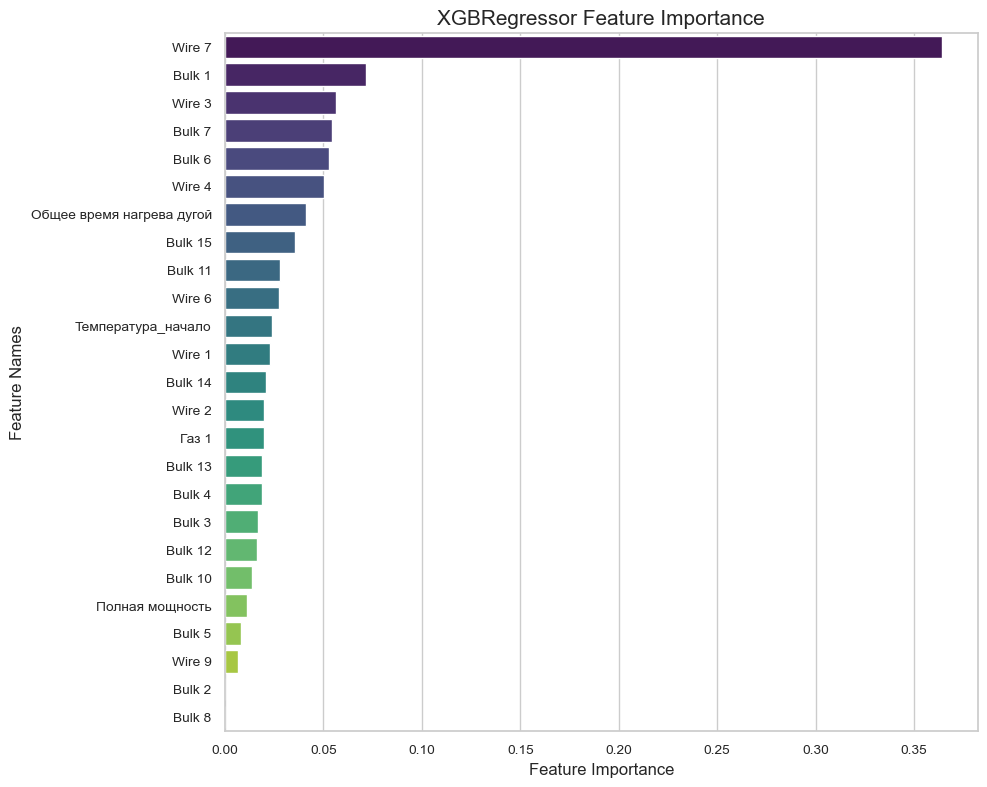

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min

In [66]:
def chart_feature_importance(importance, names, model_type):
    """
    Функция для отображения важности признаков модели.
    
    Parameters:
    - importance: Список или массив, указывающий важность каждого признака.
    - names: Список или массив с именами признаков.
    - model_type: Строка для указания типа модели в заголовке графика.
    """
    
    # Создание DataFrame для отображения важности признаков
    data = {'feature_names': names, 'feature_importance': importance}
    fi_df = pd.DataFrame(data)
    
    # Сортировка DataFrame по убыванию важности признака
    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)
    
    # Отображение графика важности признаков
    plt.figure(figsize=(10, 8))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'], palette="viridis")
    plt.title(f'{model_type} Feature Importance', fontsize=15)
    plt.xlabel('Feature Importance', fontsize=12)
    plt.ylabel('Feature Names', fontsize=12)
    plt.tight_layout()
    plt.show()

# Отображение важности признаков для модели CatBoostRegressor
chart_feature_importance(model.feature_importances_, X_test.columns, 'XGBRegressor')


# Вывод

Мы провели финальное тестирование нашей модели. 
Модель показала результат MAE 6.09 на тестовой выборке, что соответствует условию решения задачи.

Этапы:
1. Исследовательский анализ данных.
2. Обработка пропусков и выбросов, выявленных в таблицах.
3. Добавление новых признаков для модели.
4. Масштабирование признаков.
5. Обучение на следующих моделях:
   - CatBoostRegressor
   - LightGBMRegressor
   - XGboostRegressor
   - LinearRegression
6. Подбор гиперпараметров с использованием GridSearchCV.
7. Наилучший результат: MAE 6.17 на тестовой выборке с использованием XGBRegressor.


- 1. Добавил функцию cross_val_models -  кросс-валидация без поиска гиперпараметров для метрики Average CV MAE
- 2. Добавил в функцию fit строки и добавил лучший -gscv.best_score_ с поиском гиперпараметра
    -           results.append({
                'model': name,
                'train_mae_score': mean_absolute_error(train_actuals, train_predictions),
                'cv_mae_score': -gscv.best_score_,  # Здесь мы берем отрицательное значение, потому что используем 'neg_mean_absolute_error' в качестве метрики
                'best_params': gscv.best_params_
            })


- прописал test_size=0.25 в train_test_split
- в словарь params (с параметрами и моделями) записал 'random_state':[random_state]. random_state = 140823